In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def trend(time, slope=0):
    return slope* time


In [3]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 *np.pi),
                    1/np.exp(5* season_time))

In [4]:
def seasonality(time, period, amplitude =1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


In [5]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [6]:
def plot_series (time, series, format='-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += white_noise(time, noise_level, seed=42)

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [11]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [13]:
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.0207188 ],
       [-0.06157762],
       [ 0.10847417],
       [ 0.04049607],
       [-0.04280047],
       [ 0.05810029],
       [-0.04984553],
       [-0.03680975],
       [ 0.0214889 ],
       [ 0.03637647],
       [ 0.00072083],
       [ 0.00070147],
       [-0.03933552],
       [ 0.00443277],
       [ 0.00699168],
       [ 0.05287666],
       [ 0.0883459 ],
       [ 0.12903546],
       [ 0.25241917],
       [ 0.43525118]], dtype=float32), array([0.01830907], dtype=float32)]


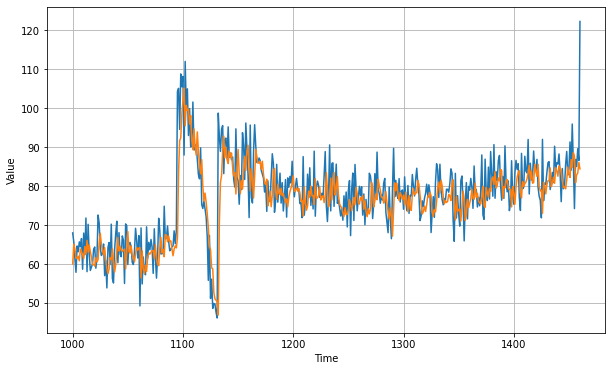

In [14]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


5.084861